In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import adjusted_rand_score

from datetime import date, timedelta

from tqdm.notebook import tqdm

pd.set_option("display.max_columns", None)
plt.style.use("ggplot")
pal = sns.color_palette()

In [2]:
data = pd.read_parquet("./data/transformed/data_merged.parquet")

In [3]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,price,freight_value,product_category_name,shipping_limit_date,nb_of_product,payment_value,payment_installments,payment_type,geolocation_lat,geolocation_lng,nb_orders,delivery_time,freight_ratio
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4.0,None,None,2017-05-26 00:00:00,2017-05-30 22:34:40,124.99,21.88,[office_furniture],2017-05-22 15:22:12,1,146.87,2,[credit_card],-20.509897,-47.397866,1,8 days 19:30:00,0.175054
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,None,None,2018-01-30 00:00:00,2018-02-10 22:43:29,289.00,46.48,[housewares],2018-01-18 20:58:32,1,335.48,8,[credit_card],-23.726853,-46.545746,1,16 days 15:52:55,0.160830
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5.0,None,None,2018-06-15 00:00:00,2018-06-15 12:10:59,139.94,17.79,[office_furniture],2018-06-05 16:19:10,1,157.73,7,[credit_card],-23.527788,-46.660310,1,26 days 01:51:06,0.127126
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5.0,None,None,2018-03-29 00:00:00,2018-04-02 18:36:47,149.94,23.36,[office_furniture],2018-03-27 16:31:16,1,173.30,1,[credit_card],-23.496930,-46.185352,1,14 days 23:57:47,0.155796
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5.0,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,230.00,22.25,[home_confort],2018-07-31 10:10:09,1,252.25,8,[credit_card],-22.987222,-47.151073,1,11 days 11:04:18,0.096739


In [4]:
data = data.sort_values("order_purchase_timestamp").reset_index(drop=True)

In [5]:
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])
data["days_since_last_purchase"] = (
    pd.to_datetime("today") - data["order_purchase_timestamp"]
).dt.days

## Kmeans RFM :

In [7]:
def make_df(date_limite="2018-09-03"):

    df = data[
        [
            "order_purchase_timestamp",
            "customer_unique_id",
            "days_since_last_purchase",
            "payment_value",
            "customer_id",
        ]
    ].copy()

    df = df.query("order_purchase_timestamp < @date_limite").sort_values(
        "order_purchase_timestamp"
    )

    df = (
        df.groupby("customer_unique_id")[
            ["days_since_last_purchase", "payment_value", "customer_id"]
        ]
        .agg(
            {
                "days_since_last_purchase": "min",
                "payment_value": "sum",
                "customer_id": "count",
            }
        )
        .reset_index()
    )

    df = df.rename({"customer_id": "nb_orders"}, axis=1)

    return df

In [8]:
df = make_df()
df.head()

,customer_unique_id,days_since_last_purchase,payment_value,nb_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1856,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1858,27.19,1
2,0000f46a3911fa3c0805444483337064,2281,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,2065,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,2032,196.89,1


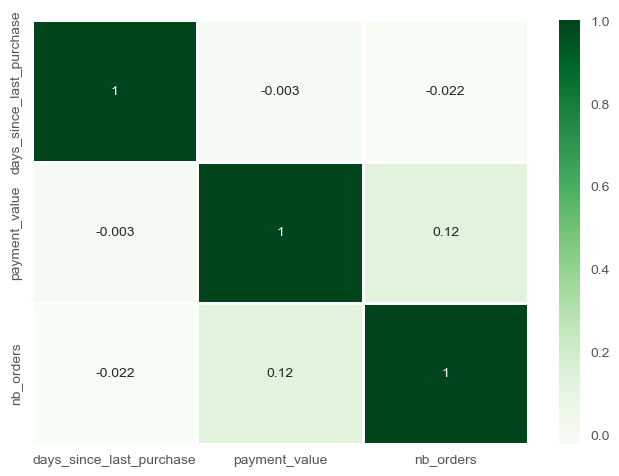

In [9]:
sns.heatmap(df.corr(), cmap="Greens", annot=True, linewidths=0.9)
plt.show()

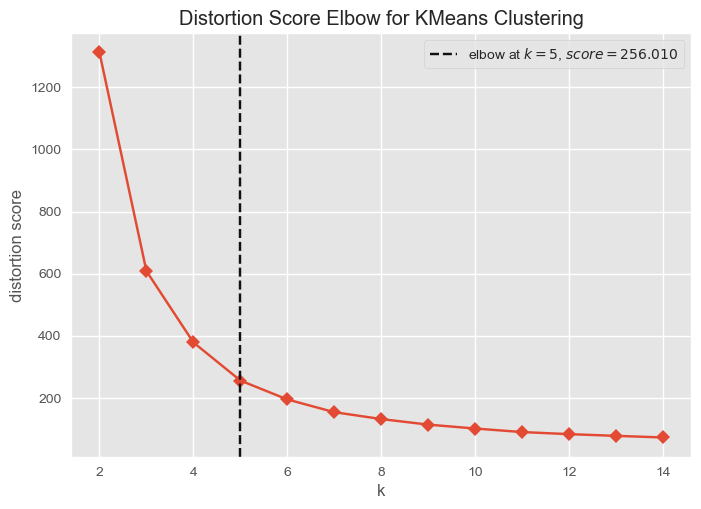

In [10]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df.drop("customer_unique_id", axis=1))

model = KMeans(random_state=14)
visualizer = KElbowVisualizer(model, k=(2, 15), timings=False)

visualizer.fit(X_scaled)
visualizer.poof()
plt.show()

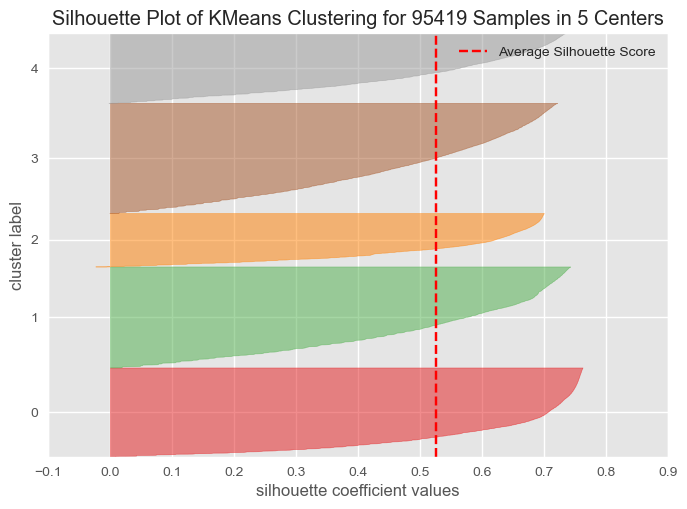

In [11]:
model = KMeans(5, random_state=14)

visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_scaled)
visualizer.poof()

plt.show()

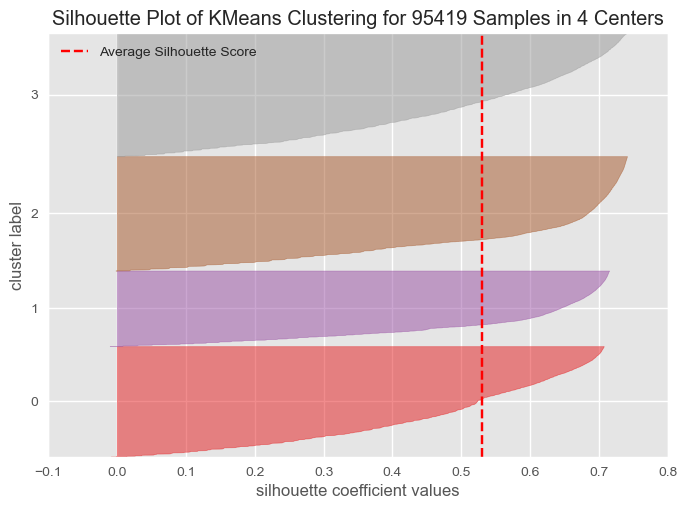

In [12]:
model = KMeans(4, random_state=14)

visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_scaled)
visualizer.poof()

plt.show()

In [13]:
clustering = KMeans(n_clusters=4, random_state=14)

df["cluster"] = clustering.fit_predict(X_scaled)

In [16]:
df["cluster"].value_counts(normalize=True)

3    0.290288
2    0.270062
0    0.261028
1    0.178623
Name: cluster, dtype: float64

In [14]:
df.groupby("cluster").mean().reset_index()

,cluster,days_since_last_purchase,payment_value,nb_orders
0,0,2058.361987,166.689118,1.032320
1,1,2228.833020,165.109950,1.025464
2,2,1806.049012,170.480303,1.039233
3,3,1927.568215,161.996712,1.035922


In [15]:
df.groupby("cluster")["nb_orders"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,24907.0,1.032320,0.190198,1.0,1.0,1.0,1.0,4.0
1,17044.0,1.025464,0.172128,1.0,1.0,1.0,1.0,6.0
2,25769.0,1.039233,0.244890,1.0,1.0,1.0,1.0,16.0
3,27699.0,1.035922,0.216916,1.0,1.0,1.0,1.0,9.0


In [23]:
df.groupby("cluster")["payment_value"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,24907.0,166.689118,230.653553,10.07,64.0000,106.97,183.545,13664.08
1,17044.0,165.109950,245.289561,12.28,61.3725,105.28,179.070,7571.63
2,25769.0,170.480303,241.420130,9.59,63.6500,111.13,186.100,7274.88
3,27699.0,161.996712,201.246929,13.36,62.7800,108.20,182.605,4175.26


In [25]:
df.groupby("cluster")["days_since_last_purchase"].describe()


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,24907.0,2058.361987,43.497185,1993.0,2021.0,2051.0,2095.0,2143.0
1,17044.0,2228.833020,59.370403,2144.0,2181.0,2220.0,2271.0,2468.0
2,25769.0,1806.049012,35.877442,1744.0,1773.0,1806.0,1839.0,1867.0
3,27699.0,1927.568215,35.152883,1867.0,1898.0,1927.0,1958.0,1993.0


In [26]:
data["cluster"] = data["customer_unique_id"]

unique_id_cluster = pd.Series(
    df["cluster"].values,
    index=df["customer_unique_id"],
).to_dict()

data["cluster"] = data["cluster"].map(unique_id_cluster)

In [27]:
data.groupby("cluster")["freight_ratio"].mean()

cluster
0    0.297612
1    0.316421
2    0.313627
3    0.308272
Name: freight_ratio, dtype: float64

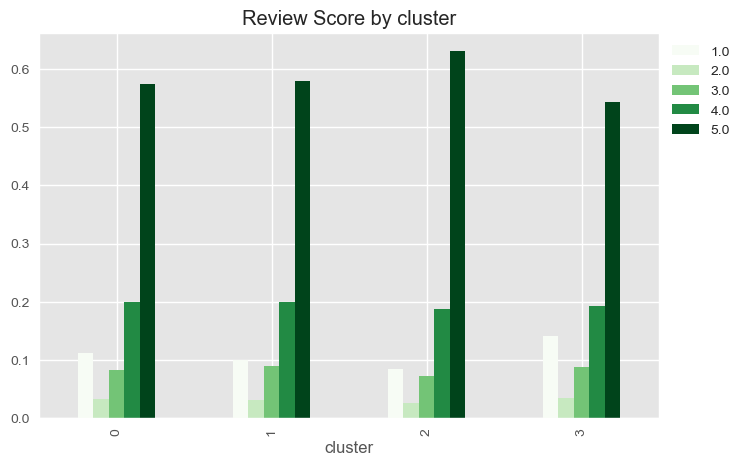

In [28]:
data.groupby("cluster")["review_score"].value_counts(normalize=True).unstack().plot(
    kind="bar",
    cmap="Greens",
    title=("Review Score by cluster"),
    figsize=(8, 5),
)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

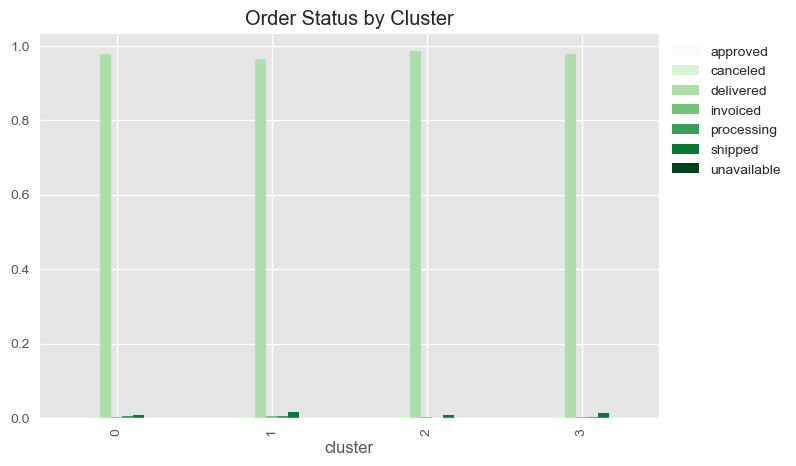

In [29]:
data.groupby("cluster")["order_status"].value_counts(normalize=True).unstack().plot(
    kind="bar",
    cmap="Greens",
    title="Order Status by Cluster",
    figsize=(8, 5),
)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [30]:
data.groupby("cluster")["payment_installments"].mean()

cluster
0    3.111232
1    3.238872
2    2.881894
3    2.803548
Name: payment_installments, dtype: float64

In [31]:
data.groupby("cluster")["nb_of_product"].mean()

cluster
0    1.147674
1    1.131766
2    1.142489
3    1.141702
Name: nb_of_product, dtype: float64

In [32]:
data["order_delivered_customer_date"] = pd.to_datetime(
    data["order_delivered_customer_date"]
)

data["delivery_time"] = (
    data["order_delivered_customer_date"] - data["order_purchase_timestamp"]
)

In [33]:
data.groupby("cluster")["delivery_time"].mean()

cluster
0   13 days 08:32:17.418866274
1   12 days 15:03:56.264723308
2    9 days 11:10:06.818923018
3   14 days 16:58:31.166150119
Name: delivery_time, dtype: timedelta64[ns]

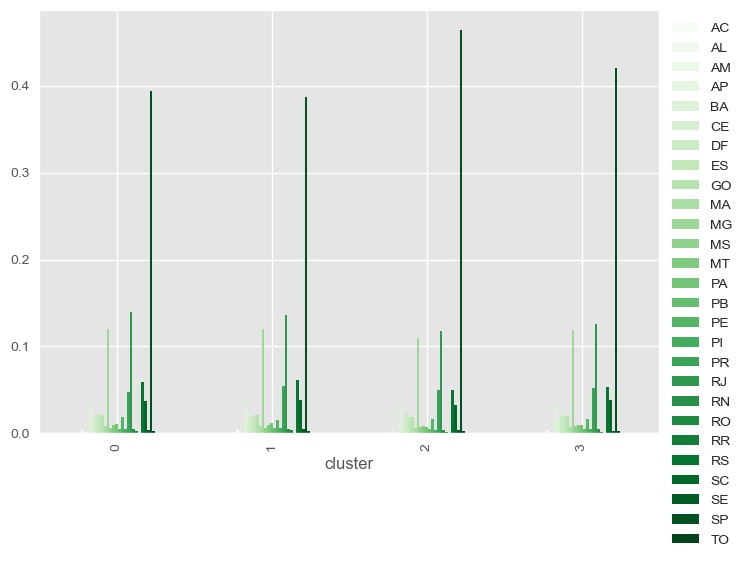

In [34]:
data.groupby("cluster")["customer_state"].value_counts(normalize=True).unstack().plot(
    kind="bar",
    cmap="Greens",
)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### ARI :

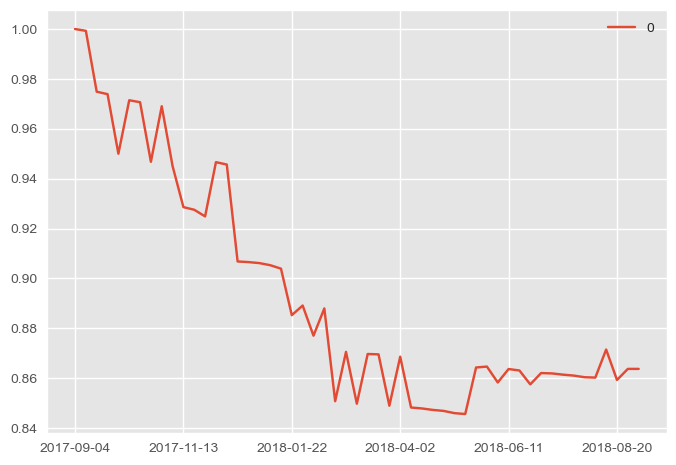

In [27]:
ari = {}

delta = timedelta(days=7)  # fréquence de calcul

start_date = date(2017, 9, 4)
end_date = date(2018, 9, 3)

df_init = make_df(start_date.strftime("%Y-%m-%d"))

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_init.drop("customer_unique_id", axis=1))

clustering = KMeans(n_clusters=4, random_state=14)
clustering.fit(X_scaled)
labels_init = clustering.labels_


while start_date <= end_date:

    df = make_df(start_date.strftime("%Y-%m-%d"))

    df = df.loc[
        df["customer_unique_id"].isin(df_init["customer_unique_id"].values)
    ].reset_index(drop=True)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(
        df.drop("customer_unique_id", axis=1),
    )

    clustering = KMeans(n_clusters=4, random_state=14)

    clustering.fit(X_scaled)

    labels = clustering.labels_

    ari[start_date.strftime("%Y-%m-%d")] = adjusted_rand_score(labels_init, labels)

    start_date += delta

pd.DataFrame.from_dict(ari, orient="index").plot()
plt.show()